Neural Style Transfer with PyTorch
============================
*In this notebook we will try to merge the worlds of popular series*

**Importing necessary packages**

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy


**Loading the pictures**

In [0]:
imsize = 1024  

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img1 = image_loader("/sezam.jpg")
style_img2 = image_loader("/rick.jpg")
content_img = image_loader("/shrek.jpg")

**Printing the pictures we will work with**

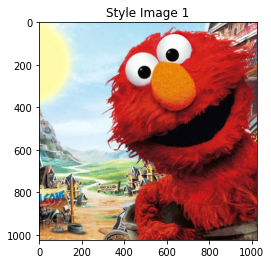

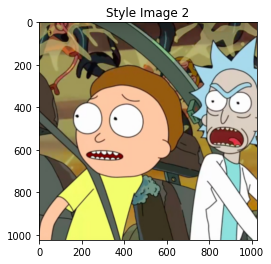

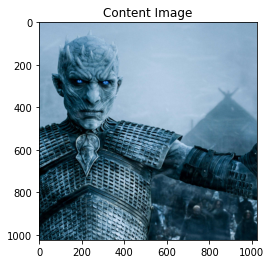

In [62]:
unloader = transforms.ToPILImage()  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 



plt.figure()
imshow(style_img1, title='Style Image 1')

plt.figure()
imshow(style_img2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

**Content Loss**

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

**Gram matrix**

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size() 
        

        features = input.view(batch_size * h, w * f_map_num)  

        G = torch.mm(features, features.t())  


        return G.div(batch_size * h * w * f_map_num)

**Style Loss**

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)
            
        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

**Normalization**


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            
            return (img - self.mean) / self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

**Pretrained model**

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


**Full model**

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   content_img, style_img1, style_img2,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        
        content_losses = []
        style_losses1 = []
        style_losses2 = []


        
        model = nn.Sequential(normalization)

        i = 0  
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()

                style_loss1 = StyleLoss(target_feature1)
                model.add_module("style_loss_1{}".format(i), style_loss1)
                style_losses1.append(style_loss1)

                style_loss2 = StyleLoss(target_feature2)
                model.add_module("style_loss_2{}".format(i), style_loss2)
                style_losses2.append(style_loss2)

        
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses1, style_losses2, content_losses

In [0]:
def get_input_optimizer(input_img):
        
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

**Train cycle**

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses1, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, content_img, style_img1, style_img2)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
               
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score1 = 0
                style_score2 = 0
                content_score = 0

                for sl1 in style_losses1:
                    style_score1 += sl1.loss

                for sl2 in style_losses2:
                    style_score2 += sl2.loss

                for cl in content_losses:
                    content_score += cl.loss
                
                style_score1 *= style_weight
                style_score2 *= style_weight
                content_score *= content_weight

                loss = style_score1 + style_score2 + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss 1 : {:4f} Style Loss 2 : {:4f} Content Loss: {:4f}'.format(
                        style_score1.item(), style_score2.item(), content_score.item()))
                    print()

                return style_score1 + style_score2 + content_score

            optimizer.step(closure)

        
        input_img.data.clamp_(0, 1)

        return input_img

**Training the model on our pictures**

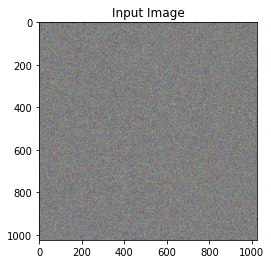

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss 1 : 142.584015 Style Loss 2 : 96.402061 Content Loss: 17.792370

run [100]:
Style Loss 1 : 85.896484 Style Loss 2 : 93.578888 Content Loss: 12.928497

run [150]:
Style Loss 1 : 84.008652 Style Loss 2 : 89.786438 Content Loss: 10.263264

run [200]:
Style Loss 1 : 83.289246 Style Loss 2 : 87.740654 Content Loss: 8.654465

run [250]:
Style Loss 1 : 82.704308 Style Loss 2 : 86.231346 Content Loss: 7.551970

run [300]:
Style Loss 1 : 82.315414 Style Loss 2 : 84.662270 Content Loss: 6.825212

run [350]:
Style Loss 1 : 82.333862 Style Loss 2 : 82.370811 Content Loss: 6.552594

run [400]:
Style Loss 1 : 79.296043 Style Loss 2 : 82.109741 Content Loss: 6.713765

run [450]:
Style Loss 1 : 78.936890 Style Loss 2 : 79.520493 Content Loss: 6.864116

run [500]:
Style Loss 1 : 77.228920 Style Loss 2 : 79.087578 Content Loss: 6.282901



In [63]:
input_img = content_img.clone()
input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, style_img2, input_img)

**Printing the result**

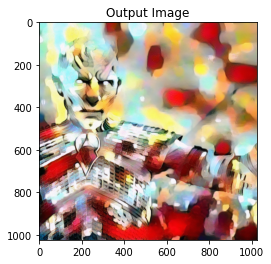

In [64]:
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()